### Question 3
Does the Northwind Customer database conform to the 80/20 rule, 80% of your sales is accounted for by 20% of your customers. 

We will answer this question by first determining if there is a statistically significant difference in the mean revenue of the top 20 percentile of customers by total revenue and that of all the customers. 


### Importing Python Module 

In [1]:
from importlib import reload

import numpy as np
import pandas as pd

import sqlite3

# Removing red warnings
import warnings
warnings.filterwarnings('ignore')

# Power Analysis
from statsmodels.stats.power import tt_ind_solve_power,ttest_power

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('ggplot')
figsize = (13,8)

import function as func

import scipy.stats as scs


ip


In [2]:
conn = func.MyConn(filename= 'Northwind_small.sqlite')

In [3]:
query =  """
            SELECT o.ID, CustomerID, ProductID, Quantity, Discount, UnitPrice
            FROM 'Order' as o
            JOIN 'OrderDetail' as od
            on o.ID = od.OrderID 
        """


In [4]:
df = conn.load_query_as_df(query)
# Line total
df['LineTotal'] = df.UnitPrice* df.Quantity

In [5]:
columns = ['Quantity', 'LineTotal']
df_customer = df.groupby('CustomerId')[columns].sum()

df_customer = df_customer.rename(columns= {'LineTotal':'Revenue'})
df_customer.head()

,Quantity,Revenue
CustomerId,,
ALFKI,174,4596.20
ANATR,63,1402.95
ANTO,359,7515.35
AROUT,650,13806.50
BERGS,1001,26968.15


In [6]:
df_customer['Top20']= df_customer.Revenue >=df_customer.Revenue.quantile(.8)


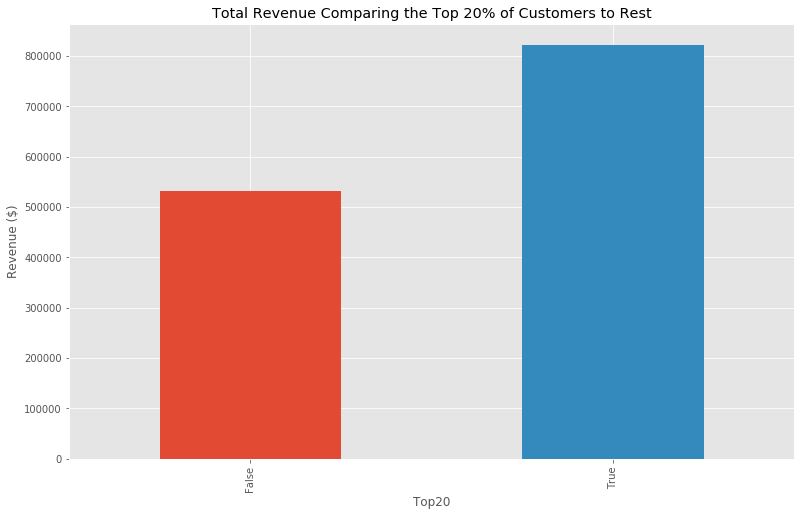

In [28]:
func.plotset(title='Total Revenue Comparing the Top 20% of Customers to Rest')
df_customer.groupby('Top20').Revenue.sum().plot(kind='bar')
plt.ylabel('Revenue ($)');

In [8]:
df_customer.groupby('Top20').count()

,Quantity,Revenue
Top20,,
False,71,71
True,18,18


In [9]:
df_customer.loc[df_customer.Revenue >=df_customer.Revenue.quantile(.8)].Revenue.sum()/ df_customer.Revenue.sum()

0.6073187442371346

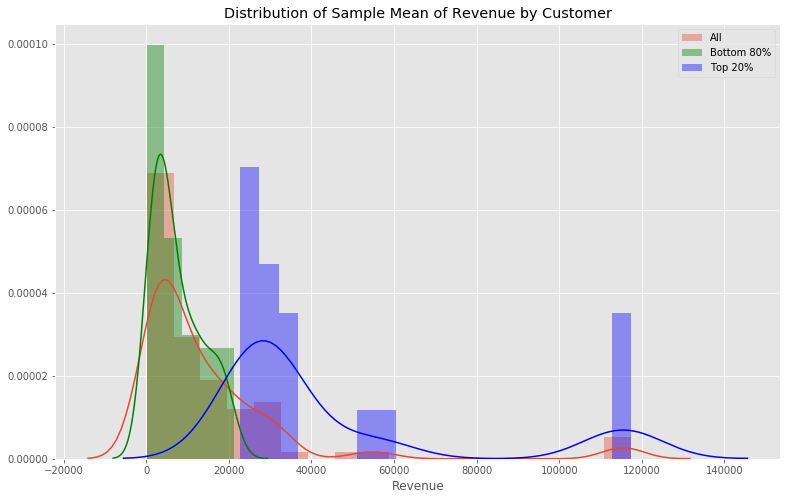

In [10]:
func.plotset(title= 'Distribution of Sample Mean of Revenue by Customer');
sns.distplot(df_customer.Revenue, label='All');
sns.distplot(df_customer.loc[df_customer.Top20 == False].Revenue, color='green', label= 'Bottom 80%');
sns.distplot(df_customer.loc[df_customer.Top20 == True].Revenue, color='blue', label= 'Top 20%', bins= 20);
plt.legend();

In [11]:
df_customer.loc[df_customer.Top20 == True].Revenue.mean()

45699.33833333333

#### Normalilty Shapiro Welk Test

In [12]:
for i in df_customer.Top20.value_counts().index:
    print(i)
    print(func.shapiro_normal(df_customer.loc[df_customer.Top20 == i].Revenue))

False
non normal
t 0.8955289721488953, p 2.296842467330862e-05
True
non normal
t 0.6525330543518066, p 2.3559050532639958e-05


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05.

*Null hypothesis was rejected.* The p-values are below the threshold, so the distrbutions are non normal. Will bootstrap.

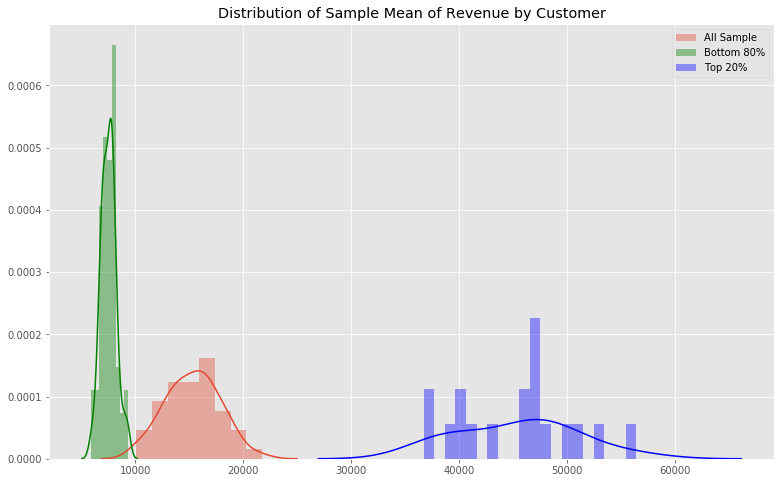

In [13]:

total = func.bootstrapping(df_customer.Revenue, num_of_samples=89)
Top20 = func.bootstrapping(df_customer.loc[df_customer.Top20 == True].Revenue, num_of_samples=18)
Bottom80 = func.bootstrapping(df_customer.loc[df_customer.Top20 == False].Revenue, num_of_samples=71)
func.plotset(title= 'Distribution of Sample Mean of Revenue by Customer');
sns.distplot(total, label='All Sample');
sns.distplot(Bottom80, color='green', label= 'Bottom 80%');
sns.distplot(Top20, color='blue', label= 'Top 20%', bins= 20);
plt.legend();

In [14]:
df_customer.Revenue.mean()

15218.63584269663

#### Normalilty Shapiro Welk Test

In [15]:
print('Total')
print(func.shapiro_normal(total))
print('Bottom 80%')
print(func.shapiro_normal(Bottom80))
print('Top 20%')
print(func.shapiro_normal(Top20))

Total
normal
t 0.9920778274536133, p 0.8747575879096985
Bottom 80%
normal
t 0.9842166304588318, p 0.5150983333587646
Top 20%
normal
t 0.9587851762771606, p 0.5783534646034241


#### Test Analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05.

*Null hypothesis was not rejected for all samples.* The p-values are below the threshold, so the distrbutions are normal. 

#### Welch T-test 

Ttest_indResult(statistic=36.64707623297512, pvalue=1.197568731338191e-61)

#### Test analysis
*Rejected the null hypothesis*(the sample means are identical)

#### Effect Size

In [17]:
effect_size = func.cohen_d(Top20, total)
effect_size

9.471090021914087

In [18]:
tt_ind_solve_power(effect_size=effect_size, nobs1=18, alpha=0.5)

1.0

In [19]:
print(np.mean(df_customer.Revenue)) 
print(np.mean(df_customer.loc[df_customer.Top20].Revenue))
print(np.mean(df_customer.loc[df_customer.Top20].Revenue) - np.mean(df_customer.Revenue))

15218.63584269663
45699.33833333333
30480.7024906367


### Conclusion 
There a statistically significant difference in the mean revenue of the top 20 percentile of customers by total revenue and that of all the customers. There is a $30,480.70 positive increase the average revenue of the whole customer base to the average revenue  among the top 20% of customers. 


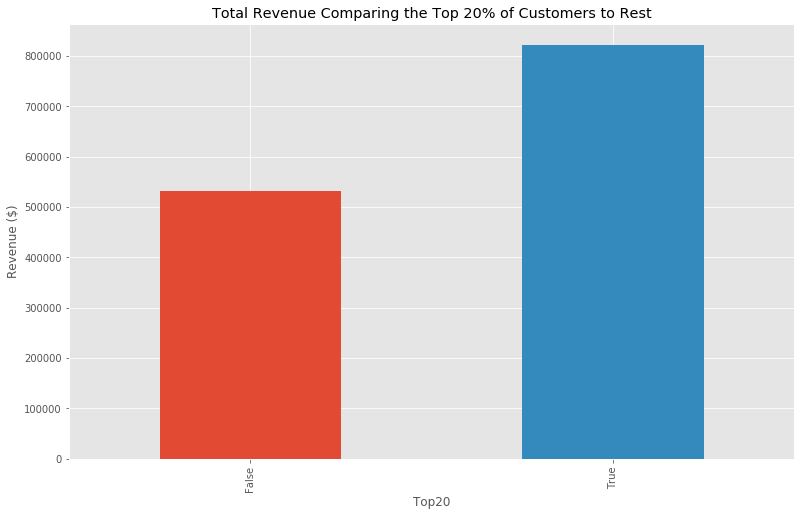

60.73% of the Revenues are from the Top 20%


In [38]:
a = round(df_customer.loc[df_customer.Top20 == True].Revenue.sum()/df_customer.Revenue.sum(), 4)*100

func.plotset(title='Total Revenue Comparing the Top 20% of Customers to Rest')
df_customer.groupby('Top20').Revenue.sum().plot(kind='bar')
plt.ylabel('Revenue ($)');
plt.show()
print(f'{a}% of the Revenues are from the Top 20%')

Only 60.73% of the revenues come from the top 20 % , but it does show the importance on focusing on the 

In [21]:
!jupyter nbconvert --to markdown question3

[NbConvertApp] Converting notebook question3.ipynb to markdown
[NbConvertApp] Support files will be in question3_files\
[NbConvertApp] Making directory question3_files
[NbConvertApp] Making directory question3_files
[NbConvertApp] Making directory question3_files
[NbConvertApp] Writing 9511 bytes to question3.md


AttributeError: 'DataFrame' object has no attribute 'BinnedDiscount'